In [ ]:
import pandas as pd
import re

# Load your CSV
df = pd.read_csv("main_updated_with_fasta_sequences.csv")  # Replace with your actual file name

invalid_mutation_data = []

for idx, row in df.iterrows():
    gene = row['GENE_NAME']
    uniprot_id = row['UniProt_ID']
    fasta_seq = str(row['FASTA_SEQUENCE']).strip()
    mutation_str = str(row['MUTATION_AA'])

    invalid_mutations = []

    # Split mutations by '|'
    mutations = [mut.strip() for mut in mutation_str.split('|') if mut.strip().startswith('p.')]

    for mut in mutations:
        match = re.match(r"p\.([A-Z])(\d+)([A-Z=])?", mut)
        if match:
            original_aa = match.group(1)
            pos = int(match.group(2))

            # Make sure position is within range of the sequence
            if 1 <= pos <= len(fasta_seq):
                actual_aa = fasta_seq[pos - 1]  # 0-based index
                if actual_aa != original_aa:
                    invalid_mutations.append(mut)
            else:
                invalid_mutations.append(mut)

    if invalid_mutations:
        invalid_mutation_data.append({
            'GENE_NAME': gene,
            'UniProt_ID': uniprot_id,
            'Invalid_Mutations': ' | '.join(invalid_mutations)
        })

# Save to CSV
invalid_df = pd.DataFrame(invalid_mutation_data)
invalid_df.to_csv("invalid_mutations.csv", index=False)
print("Invalid mutations saved to 'invalid_mutations.csv'")


Invalid mutations saved to 'invalid_mutations.csv'


In [ ]:
import pandas as pd

# Load both files
main_df = pd.read_csv("main_updated_with_fasta_sequences.csv")
invalid_df = pd.read_csv("invalid_mutations.csv")

# Clean up mutations in main_df
for _, row in invalid_df.iterrows():
    gene = row['GENE_NAME']
    invalid_mutations = [mut.strip() for mut in row['Invalid_Mutations'].split('|') if mut.strip()]

    # Find matching gene row in main_df
    main_mask = main_df['GENE_NAME'] == gene
    if main_mask.any():
        current_mutations = main_df.loc[main_mask, 'MUTATION_AA'].values[0]
        current_mutations_list = [mut.strip() for mut in current_mutations.split('|') if mut.strip()]

        # Remove invalid ones
        updated_mutations = [m for m in current_mutations_list if m not in invalid_mutations]
        updated_mutation_str = ' | '.join(updated_mutations)

        # Update the value in main_df
        main_df.loc[main_mask, 'MUTATION_AA'] = updated_mutation_str

# Save cleaned result
main_df.to_csv("main_cleaned_fasta_sequences.csv", index=False)


In [ ]:
import pandas as pd

# Load original and cleaned CSVs
original_df = pd.read_csv("main_updated_with_fasta_sequences.csv")
cleaned_df = pd.read_csv("main_cleaned_fasta_sequences.csv")

# Count mutations in each row for both files
original_df['Original_Count'] = original_df['MUTATION_AA'].apply(lambda x: len([m for m in str(x).split('|') if m.strip()]))
cleaned_df['Cleaned_Count'] = cleaned_df['MUTATION_AA'].apply(lambda x: len([m for m in str(x).split('|') if m.strip()]))

# Merge counts for comparison
comparison_df = original_df[['GENE_NAME', 'Original_Count']].merge(
    cleaned_df[['GENE_NAME', 'Cleaned_Count']], on='GENE_NAME', how='left'
)

# Calculate how many mutations were removed
comparison_df['Mutations_Removed'] = comparison_df['Original_Count'] - comparison_df['Cleaned_Count']

# Save the comparison report
comparison_df.to_csv("mutation_cleaning_report.csv", index=False)

print("Comparison report saved as 'mutation_cleaning_report.csv'")


Comparison report saved as 'mutation_cleaning_report.csv'


In [ ]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("main_updated_with_fasta_sequences.csv")

# Define position columns (Position_1 to Position_20)
position_cols = [f'Position_{i}' for i in range(1, 21)]

# Function to count valid positions (non-NaN) for each gene
df['Valid_Positions'] = df[position_cols].notna().sum(axis=1)

# Filter rows where the number of valid positions is greater than or equal to 5
filtered_df = df[df['Valid_Positions'] >= 5]

# Save the filtered data to a new CSV file
filtered_df.to_csv("filtered_gene_data.csv", index=False)

# Optional: Print the number of genes remaining
print(f"Number of genes with 5 or more positions: {filtered_df.shape[0]}")


Number of genes with 5 or more positions: 2412


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the CSV
df = pd.read_csv("filtered_gene_data.csv")

# Binding site position columns
position_cols = [f'Position_{i}' for i in range(1, 21)]

# --- Helper: Parse each position entry into a list of ints ---
def parse_position(pos):
    if pd.isna(pos):
        return []
    if isinstance(pos, str) and '-' in pos:
        try:
            start, end = map(int, pos.strip().split('-'))
            return list(range(start, end + 1))
        except:
            return []
    try:
        return [int(float(pos))]
    except:
        return []

# --- Helper: Extract all mutation positions from the AA mutation field ---
def extract_all_mutation_positions(mutation_str):
    if pd.isna(mutation_str):
        return []
    mutations = [m.strip() for m in mutation_str.split('|')]
    positions = []
    for m in mutations:
        match = re.search(r'(\d+)', m)
        if match:
            positions.append(int(match.group(1)))
    return positions

# --- Main processing ---
summary = []
total_mutations_all = 0
genes_with_binding = 0
genes_without_binding = 0

for idx, row in df.iterrows():
    gene = row['GENE_NAME']
    uniprot = row['UniProt_ID']
    mutation_str = row['MUTATION_AA']

    # Extract mutations
    mutation_positions = extract_all_mutation_positions(mutation_str)
    total_mutations = len(mutation_positions)
    total_mutations_all += total_mutations

    # Extract binding positions
    binding_positions = []
    for col in position_cols:
        binding_positions.extend(parse_position(row[col]))
    binding_positions = set(binding_positions)

    # Match mutations to binding positions
    in_binding = [pos for pos in mutation_positions if pos in binding_positions]
    binding_count = len(in_binding)
    non_binding_count = total_mutations - binding_count
    binding_percentage = (binding_count / total_mutations) * 100 if total_mutations > 0 else 0

    if binding_count > 0:
        genes_with_binding += 1
    else:
        genes_without_binding += 1

    summary.append({
        "GENE_NAME": gene,
        "UniProt_ID": uniprot,
        "Total_Mutations": total_mutations,
        "In_Binding": binding_count,
        "Outside_Binding": non_binding_count,
        "Binding_Percentage": round(binding_percentage, 2)
    })

# Save results
summary_df = pd.DataFrame(summary)
summary_df.to_csv("per_gene_binding_mutation_mapping.csv", index=False)


Total entries (genes): 2412
Total extracted mutations: 844,538
Mutations in binding regions: 16,612
Mutations outside binding regions: 827,926
Percentage in binding regions: 1.97%


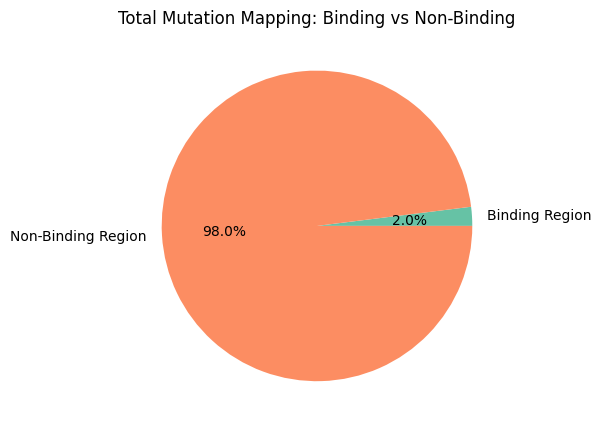

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the per-gene summary file
df = pd.read_csv("per_gene_binding_mutation_mapping.csv")

# Total mutation stats
total_genes = len(df)
total_mutations = df['Total_Mutations'].sum()
total_binding = df['In_Binding'].sum()
total_non_binding = df['Outside_Binding'].sum()
binding_percentage = (total_binding / total_mutations) * 100 if total_mutations else 0

# Print summary
print(f"Total entries (genes): {total_genes}")
print(f"Total extracted mutations: {total_mutations:,}")
print(f"Mutations in binding regions: {total_binding:,}")
print(f"Mutations outside binding regions: {total_non_binding:,}")
print(f"Percentage in binding regions: {binding_percentage:.2f}%")

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [total_binding, total_non_binding],
    labels=['Binding Region', 'Non-Binding Region'],
    autopct='%1.1f%%',
    colors=['#66c2a5', '#fc8d62']
)
plt.title('Total Mutation Mapping: Binding vs Non-Binding')
plt.tight_layout()
plt.show()
